In [204]:
import os
import sys
from optparse import OptionParser

import numpy as np
import scipy as ci 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
# from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables 
import warnings
from scipy.optimize import minimize
warnings.filterwarnings('once')

In [205]:
lifetime = 86400*365 # 1 year! 

In [206]:
# ineff model parameters 
params = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model.txt')
def ineff_model(dist,E): # must pass in LOG of energy!!! 
    a = params[0] + params[2] * (E + params[1])**2 
    b = params[3] + params[5] * (E + params[4])**2
    val = 10 * a / dist**(1/3.) * np.exp( -10**6 * b / dist**2)
    val[val < 0.005] = 0.005
    return val

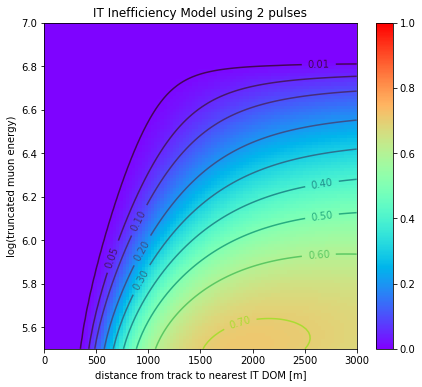

In [207]:
xt = np.linspace(0.001,3000,100) # dist 
yt = np.linspace(5.5,7,100)  # E 
xg,yg = np.meshgrid(xt,yt)
zg_2 = ineff_model(xg,yg)

# if ineff < 0, change to 0! 
zg_2[zg_2<0] = 0

plt.figure(figsize=(7,6))
plt.pcolormesh(xg,yg,zg_2,cmap='rainbow',shading='flat')
plt.colorbar()
plt.clim(0,1) # colorbar limit
CS=plt.contour(xg,yg,zg_2,levels=[0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
plt.clabel(CS,inline=1,fmt='%1.2f',fontsize=10)
plt.xlabel('distance from track to nearest IT DOM [m]')
plt.ylabel('log(truncated muon energy)')
plt.xlim(0,3000)
plt.ylim(5.5,7)
plt.title('IT Inefficiency Model using 2 pulses')
plt.show()

<font color ='darkorange'><font size = 6> global cut

In [267]:
pcut1 = 5.47 # y center
pcut2 = 1.2
pcut3 = 1.1 # x center
pcut4 = 0.68

radius = 2.3
coszencut = 0.13
# if use (r = 2.3, coszen = 0.13) phase cut in rf without dnn: Sig = 3.2, S/N = 3.8
# global opt result: [2.6        0.17       0.39       0.59]
chi2_red_cut = 0.23
pom_cut = 0.44

IT_ineff_cut = 1

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11057.h5','r') as f:
    n_file = 72701 # with _rf, the size of broken file is 266K instead of 0! 
    
    CUT_chi2_red = f.root.Collection.cols.chi2[:]/f.root.Collection.cols.NDF[:] > chi2_red_cut
    CUT_pom = np.log10(f.root.Collection.cols.PeakOverMedian[:]) > pom_cut
        
    ineff_corsika = ineff_model(f.root.IT_veto_closest_approach_dist_to_nearest_dom_muon.cols.value[:],np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]))
    CUT_ineff = ineff_corsika < IT_ineff_cut

    CUT_zenith = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]
    CUT_truncated_muon_e = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]
    CUT_P1 = (np.cos(CUT_zenith) >= coszencut) & (np.log10(CUT_truncated_muon_e) > pcut1 + pcut2*np.sqrt(radius - ((np.cos(CUT_zenith) - pcut3)/pcut4)**2 ))
    CUT_P2 = (np.cos(CUT_zenith) < coszencut)
    CUT_phase = np.any([CUT_P1, CUT_P2],axis=0)
    
    CUT = CUT_ineff & CUT_chi2_red & CUT_pom & CUT_phase

    chi2_corsika = f.root.Collection.cols.chi2[:][CUT]
    ndf_corsika = f.root.Collection.cols.NDF[:][CUT]
    chi2_red_corsika = chi2_corsika/ndf_corsika
    PeakOverMedian_corsika = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_reco_corsika = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:][CUT]
    truncated_muon_e_corsika = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:][CUT]
    signal_dnn_corsika = f.root.DeepLearningReco_nersc_gnn_weighted_02.cols.is_signal[:][CUT]
    
    weight_corsika = f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file
    
    # before 
    zenith_reco_corsika_before =f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]
    truncated_muon_e_corsika_before = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]
    weight_corsika_before = f.root.Weight_GaisserH4a.cols.value[:] * lifetime/n_file

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11374.h5','r') as f:
    n_file = 18989

    CUT_chi2_red = f.root.Collection.cols.chi2[:]/f.root.Collection.cols.NDF[:] > chi2_red_cut
    CUT_pom = np.log10(f.root.Collection.cols.PeakOverMedian[:]) > pom_cut
    
    CUT_zenith = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]
    CUT_truncated_muon_e = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]
    CUT_P1 = (np.cos(CUT_zenith) >= coszencut) & (np.log10(CUT_truncated_muon_e) > pcut1 + pcut2*np.sqrt(radius - ((np.cos(CUT_zenith) - pcut3)/pcut4)**2 ))
    CUT_P2 = (np.cos(CUT_zenith) < coszencut) 
    CUT_phase = np.any([CUT_P1, CUT_P2],axis=0)

    ineff_numu = ineff_model(f.root.IT_veto_closest_approach_dist_to_nearest_dom_muon.cols.value[:],np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]))
    CUT_ineff = ineff_numu < IT_ineff_cut

    CUT = CUT_ineff & CUT_chi2_red & CUT_pom & CUT_phase

    chi2_numu = f.root.Collection.cols.chi2[:][CUT]
    ndf_numu = f.root.Collection.cols.NDF[:][CUT]
    chi2_red_numu = chi2_numu/ndf_numu    
    PeakOverMedian_numu = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_reco_numu = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:][CUT]
    truncated_muon_e_numu = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:][CUT]
    signal_dnn_numu = f.root.DeepLearningReco_nersc_gnn_weighted_02.cols.is_signal[:][CUT]

    ### astrophysical ###
    energy = f.root.MCPrimary.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_numu_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    
    # before
    zenith_reco_numu_before = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]
    truncated_muon_e_numu_before = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]
    energy = f.root.MCPrimary.cols.energy[:]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:]
    weight_numu_astro_before = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: The following kwargs were not used by contour: 'lw'


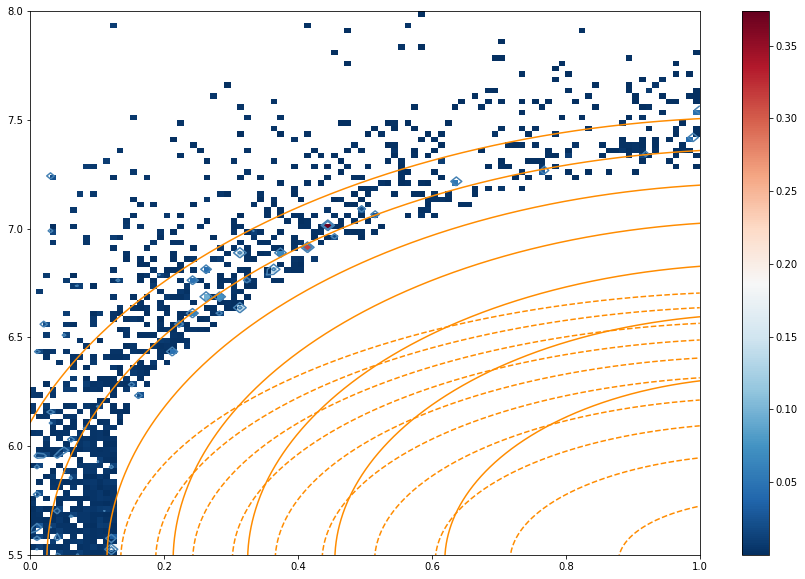

In [268]:
# ----- transform phase space ----- 
my_cmap = plt.cm.get_cmap('RdBu_r')
my_cmap.set_under('w')

plt.figure(figsize=(15,10))
h_,yy_,xx_,img_=plt.hist2d(np.concatenate((np.cos(zenith_reco_corsika),np.cos(zenith_reco_numu))),
            np.concatenate((np.log10(truncated_muon_e_corsika),np.log10(truncated_muon_e_numu))),cmap=my_cmap,
            bins=100,range=[[0,1],[5.5,8]],weights=np.concatenate((weight_corsika,weight_numu_astro)),vmin = 0.0001)
plt.colorbar()

# near region 
p1 = 5.47 # y center
p2 = 0.9
p3 = 1.1 # x center
p4 = 0.7

t = np.arange(0,1,0.0001)
for i, c in enumerate(np.arange(0.1,2,0.2)):
    plt.plot(t, p1 + p2*np.sqrt(c - ((t - p3)/p4)**2  ),'--',color='darkorange')

# far region 
p1 = 5.47 # y center
p2 = 1.2
p3 = 1.1 # x center
p4 = 0.68

t = np.arange(0,1,0.0001)
for i, c in enumerate(np.arange(0.5,3,0.4)):
    plt.plot(t, p1 + p2*np.sqrt(c - ((t - p3)/p4)**2  ),'-',color='darkorange')

CS=plt.contour(h_.transpose(),extent=[0,1,5.5,8],lw=1,levels=[0.01,0.1,1,10,30,50,100,200,300,400,500,1000],colors='steelblue')
plt.clabel(CS,inline=1,fmt='%1.2f',fontsize=10,colors='red')

plt.show()

In [269]:
print('astro numu:',np.sum(weight_numu_astro))
print('corsika:',np.sum(weight_corsika))
print('S/N:',np.sum(weight_numu_astro)/np.sum(weight_corsika))

astro numu: 2.746162826197377
corsika: 2.4520465018846385
S/N: 1.1199472865162554


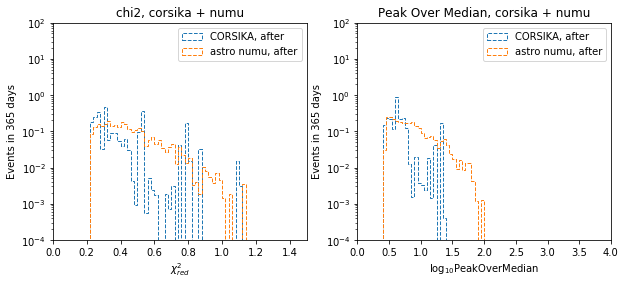

In [270]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist(chi2_red_corsika,bins=np.arange(0,1.5,0.02),log=True,histtype='step',linestyle='--',lw=1,label='CORSIKA, after',weights=weight_corsika,bottom=10**(-6))
plt.hist(chi2_red_numu,bins=np.arange(0,1.5,0.02),log=True,histtype='step',linestyle='--',lw=1,label='astro numu, after',weights=weight_numu_astro,bottom=10**(-6))
plt.xlabel(r'$\chi^2_{red}$')
plt.ylabel('Events in 365 days')
plt.xlim(0,1.5)
plt.ylim(10**(-4),10**2)
plt.legend()
plt.title('chi2, corsika + numu')

plt.subplot(122)
plt.hist(np.log10(PeakOverMedian_corsika),bins=np.arange(0,10.2,0.05),log=True,histtype='step',linestyle='--',lw=1,label='CORSIKA, after',weights=weight_corsika,bottom=10**(-6))
plt.hist(np.log10(PeakOverMedian_numu),bins=np.arange(0,10.2,0.05),log=True,histtype='step',linestyle='--',lw=1,label='astro numu, after',weights=weight_numu_astro,bottom=10**(-6))
plt.xlabel(r'$\log_{10}$PeakOverMedian')
plt.ylabel('Events in 365 days')
plt.xlim(0,4)
plt.ylim(10**(-4),10**2)
plt.legend()
plt.title('Peak Over Median, corsika + numu')
plt.show()

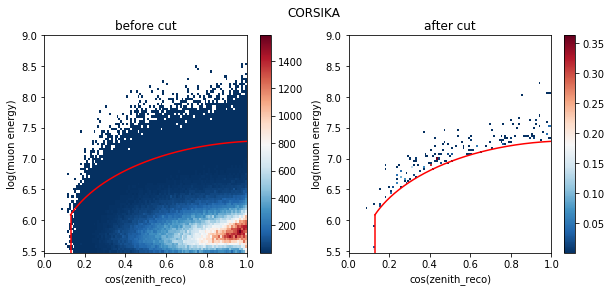

In [102]:
plt.figure(figsize=(10,4))

my_cmap = plt.cm.get_cmap('RdBu_r')
my_cmap.set_under('w')

plt.subplot(121)
plt.hist2d(np.cos(zenith_reco_corsika_before),np.log10(truncated_muon_e_corsika_before),bins=100,weights=weight_corsika_before,cmap=my_cmap,vmin = 0.001) 
plt.xlabel('cos(zenith_reco)')
plt.ylabel('log(muon energy)')
plt.xlim(0,1)
plt.ylim(5.47,9.)
plt.title('before cut')
plt.colorbar()
# E vs zen boundary
t = np.arange(coszencut,1,0.002)
y =  pcut1 + pcut2*np.sqrt(radius - ((t - pcut3)/pcut4)**2)
plt.plot(t,y,'-',color='red')
plt.plot(np.array([coszencut,t[0]]),np.array([0,y[0]]),'-',color='red')

plt.subplot(122)
plt.hist2d(np.cos(zenith_reco_corsika),np.log10(truncated_muon_e_corsika),bins=100,weights=weight_corsika,cmap=my_cmap,vmin = 0.001) 
plt.xlabel('cos(zenith_reco)')
plt.ylabel('log(muon energy)')
plt.xlim(0,1)
plt.ylim(5.47,9.)
plt.title('after cut')
plt.colorbar()
plt.suptitle('CORSIKA')
# E vs zen boundary
t = np.arange(coszencut,1,0.002)
y =  pcut1 + pcut2*np.sqrt(radius - ((t - pcut3)/pcut4)**2)
plt.plot(t,y,'-',color='red')
plt.plot(np.array([coszencut,t[0]]),np.array([0,y[0]]),'-',color='red')
plt.show()

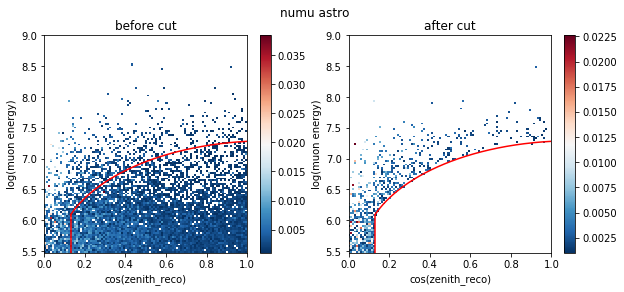

In [101]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.hist2d(np.cos(zenith_reco_numu_before),np.log10(truncated_muon_e_numu_before),bins=100,weights=weight_numu_astro_before,cmap=my_cmap,vmin = 0.001) 
plt.xlabel('cos(zenith_reco)')
plt.ylabel('log(muon energy)')
plt.xlim(0,1)
plt.ylim(5.47,9.)
plt.title('before cut')
plt.colorbar()
# E vs zen boundary
t = np.arange(coszencut,1,0.002)
y =  pcut1 + pcut2*np.sqrt(radius - ((t - pcut3)/pcut4)**2)
plt.plot(t,y,'-',color='red')
plt.plot(np.array([coszencut,t[0]]),np.array([0,y[0]]),'-',color='red')

plt.subplot(122)
plt.hist2d(np.cos(zenith_reco_numu),np.log10(truncated_muon_e_numu),bins=100,weights=weight_numu_astro,cmap=my_cmap,vmin = 0.001) 
plt.xlabel('cos(zenith_reco)')
plt.ylabel('log(muon energy)')
plt.xlim(0,1)
plt.ylim(5.47,9.)
plt.title('after cut')
plt.colorbar()
plt.suptitle('numu astro')
# E vs zen boundary
t = np.arange(coszencut,1,0.002)
y =  pcut1 + pcut2*np.sqrt(radius - ((t - pcut3)/pcut4)**2)
plt.plot(t,y,'-',color='red')
plt.plot(np.array([coszencut,t[0]]),np.array([0,y[0]]),'-',color='red')
plt.show()

# ineff < 0.01

In [83]:
pcut1 = 5.47 # y center
pcut2 = 1.2
pcut3 = 1.1 # x center
pcut4 = 0.68

radius = 1.
coszencut = 0.25
# if use above (r = 2.3, coszen = 0.13) phase cut in rf without dnn: Sig = 3.2, S/N = 3.8

chi2_red_cut = 0.36
pom_cut = 0.5

IT_ineff_cut = 0.2

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11057.h5','r') as f:
    n_file = 72701 # with _rf, the size of broken file is 266K instead of 0! 
    
    CUT_chi2_red = f.root.Collection.cols.chi2[:]/f.root.Collection.cols.NDF[:] > chi2_red_cut
    CUT_pom = np.log10(f.root.Collection.cols.PeakOverMedian[:]) > pom_cut
        
    ineff_corsika = ineff_model(f.root.IT_veto_closest_approach_dist_to_nearest_dom_muon.cols.value[:],np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]))
    CUT_ineff = ineff_corsika < IT_ineff_cut

    CUT_zenith = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]
    CUT_truncated_muon_e = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]
    CUT_P1 = (np.cos(CUT_zenith) >= coszencut) & (np.log10(CUT_truncated_muon_e) > pcut1 + pcut2*np.sqrt(radius - ((np.cos(CUT_zenith) - pcut3)/pcut4)**2 ))
    CUT_P2 = (np.cos(CUT_zenith) < coszencut)
    CUT_phase = np.any([CUT_P1, CUT_P2],axis=0)
    
    CUT = CUT_ineff & CUT_chi2_red & CUT_pom & CUT_phase

    chi2_corsika = f.root.Collection.cols.chi2[:][CUT]
    ndf_corsika = f.root.Collection.cols.NDF[:][CUT]
    chi2_red_corsika = chi2_corsika/ndf_corsika
    PeakOverMedian_corsika = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_reco_corsika = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:][CUT]
    truncated_muon_e_corsika = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:][CUT]
    
    weight_corsika = f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file
    
    # before 
    zenith_reco_corsika_before =f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]
    truncated_muon_e_corsika_before = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]
    weight_corsika_before = f.root.Weight_GaisserH4a.cols.value[:] * lifetime/n_file

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11374.h5','r') as f:
    n_file = 18989

    CUT_chi2_red = f.root.Collection.cols.chi2[:]/f.root.Collection.cols.NDF[:] > chi2_red_cut
    CUT_pom = np.log10(f.root.Collection.cols.PeakOverMedian[:]) > pom_cut

    ineff_numu = ineff_model(f.root.IT_veto_closest_approach_dist_to_nearest_dom_muon.cols.value[:],np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]))
    CUT_ineff = ineff_numu < IT_ineff_cut
    
    CUT_zenith = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]
    CUT_truncated_muon_e = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]
    CUT_P1 = (np.cos(CUT_zenith) >= coszencut) & (np.log10(CUT_truncated_muon_e) > pcut1 + pcut2*np.sqrt(radius - ((np.cos(CUT_zenith) - pcut3)/pcut4)**2 ))
    CUT_P2 = (np.cos(CUT_zenith) < coszencut) 
    CUT_phase = np.any([CUT_P1, CUT_P2],axis=0)

    CUT = CUT_ineff & CUT_chi2_red & CUT_pom & CUT_phase

    chi2_numu = f.root.Collection.cols.chi2[:][CUT]
    ndf_numu = f.root.Collection.cols.NDF[:][CUT]
    chi2_red_numu = chi2_numu/ndf_numu    
    PeakOverMedian_numu = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_reco_numu = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:][CUT]
    truncated_muon_e_numu = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:][CUT]

    ### astrophysical ###
    energy = f.root.MCPrimary.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_numu_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    
    # before
    zenith_reco_numu_before = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]
    truncated_muon_e_numu_before = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]
    energy = f.root.MCPrimary.cols.energy[:]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:]
    weight_numu_astro_before = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: The following kwargs were not used by contour: 'lw'


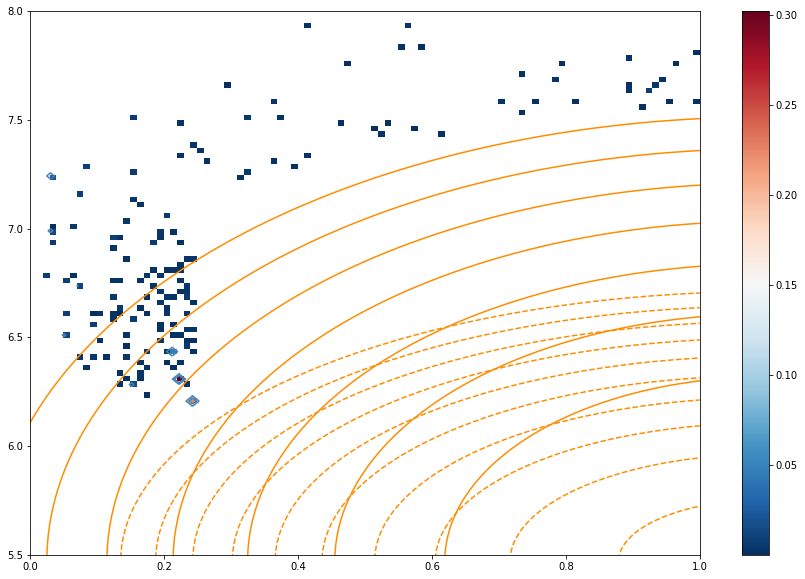

In [84]:
# ----- transform phase space ----- 
my_cmap = plt.cm.get_cmap('RdBu_r')
my_cmap.set_under('w')

plt.figure(figsize=(15,10))
h_,yy_,xx_,img_=plt.hist2d(np.concatenate((np.cos(zenith_reco_corsika),np.cos(zenith_reco_numu))),
            np.concatenate((np.log10(truncated_muon_e_corsika),np.log10(truncated_muon_e_numu))),cmap=my_cmap,
            bins=100,range=[[0,1],[5.5,8]],weights=np.concatenate((weight_corsika,weight_numu_astro)),vmin = 0.0001)
plt.colorbar()

# near region 
p1 = 5.47 # y center
p2 = 0.9
p3 = 1.1 # x center
p4 = 0.7

t = np.arange(0,1,0.0001)
for i, c in enumerate(np.arange(0.1,2,0.2)):
    plt.plot(t, p1 + p2*np.sqrt(c - ((t - p3)/p4)**2  ),'--',color='darkorange')

# far region 
p1 = 5.47 # y center
p2 = 1.2
p3 = 1.1 # x center
p4 = 0.68

t = np.arange(0,1,0.0001)
for i, c in enumerate(np.arange(0.5,3,0.4)):
    plt.plot(t, p1 + p2*np.sqrt(c - ((t - p3)/p4)**2  ),'-',color='darkorange')

CS=plt.contour(h_.transpose(),extent=[0,1,5.5,8],lw=1,levels=[0.01,0.1,1,10,30,50,100,200,300,400,500,1000],colors='steelblue')
plt.clabel(CS,inline=1,fmt='%1.2f',fontsize=10,colors='red')

plt.show()

In [85]:
print('astro numu:',np.sum(weight_numu_astro))
print('corsika:',np.sum(weight_corsika))
print('S/N:',np.sum(weight_numu_astro)/np.sum(weight_corsika))

astro numu: 0.48328944666939483
corsika: 0.6242051789608103
S/N: 0.7742477360953415


# global optimization

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


ValueError: num must be 1 <= num <= 100, not 101

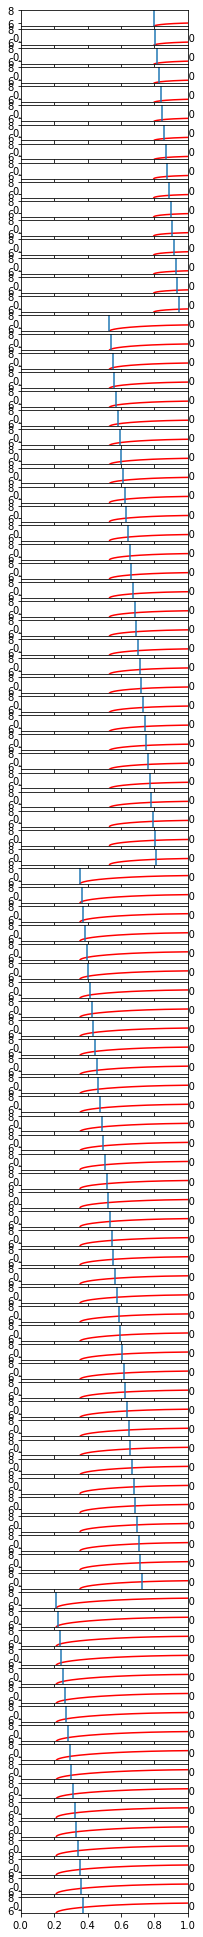

In [31]:
plt.figure(figsize=(3,35))
i=0
for radius in np.arange(0.2,2.6,0.5):
    intercep1 = pcut3-np.sqrt(radius)*pcut4
    intercep2 = pcut3-0.5*np.sqrt(radius)*pcut4
    for coszencut in np.arange(intercep1,intercep2, 0.01):
        i+=1
#         print(radius,coszencut)
        t = np.arange(0,1,0.002)
        y =  pcut1 + pcut2*np.sqrt(radius - ((t - pcut3)/pcut4)**2)
        plt.subplot(100,1,i)
        plt.plot(t,y,'-',color='red')
        plt.axvline(coszencut)
#         plt.axvline(pcut3-0.5*np.sqrt(radius)*pcut4)

        plt.xlim(0,1)
        plt.ylim(5.5,8)
plt.show()

In [284]:
PARAMS = []

pcut1 = 5.47 # y center
pcut2 = 1.2
pcut3 = 1.1 # x center
pcut4 = 0.68

IT_ineff_cut = 1

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11057.h5','r') as f:
    n_file_corsika = 72701 # with _rf, the size of broken file is 266K instead of 0! 
    
    CUT_CORSIKA_chi2_red = f.root.Collection.cols.chi2[:]/f.root.Collection.cols.NDF[:]
    CUT_CORSIKA_pom = np.log10(f.root.Collection.cols.PeakOverMedian[:])

    CUT_CORSIKA_zenith = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]
    CUT_CORSIKA_truncated_muon_e = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]

    ineff_corsika = ineff_model(f.root.IT_veto_closest_approach_dist_to_nearest_dom_muon.cols.value[:],np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]))

    weight_corsika_orig = f.root.Weight_GaisserH4a.cols.value[:] * lifetime/n_file_corsika

    
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11374.h5','r') as f:
    n_file_numu = 18989
    
    CUT_NUMU_chi2_red = f.root.Collection.cols.chi2[:]/f.root.Collection.cols.NDF[:] 
    CUT_NUMU_pom = np.log10(f.root.Collection.cols.PeakOverMedian[:])

    CUT_NUMU_zenith = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]
    CUT_NUMU_truncated_muon_e = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]

    ineff_numu = ineff_model(f.root.IT_veto_closest_approach_dist_to_nearest_dom_muon.cols.value[:],np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]))

    energy_orig = f.root.MCPrimary.cols.energy[:]
    OneWeight_orig = f.root.I3MCWeightDict.cols.OneWeight[:]
    NEvents_orig = f.root.I3MCWeightDict.cols.NEvents[:]
    weight_numu_astro_orig = (6.7 * 10**(-18))/6 * (energy_orig/10**5)**(-2) * OneWeight_orig/(n_file_numu * NEvents_orig) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar

# for radius in np.arange(2,3,0.1):
# #     intercep1 = pcut3-np.sqrt(radius)*pcut4
# #     intercep2 = pcut3-0.1*np.sqrt(radius)*pcut4
# #     for coszencut in np.arange(np.max([intercep1,0]), intercep2+0.001,3):
#     for coszencut in np.arange(0.1,0.3,0.01):
#         for chi2_red_cut in np.arange(0.2,0.4,0.01):
#             for pom_cut in np.arange(0.4,0.6,0.01):

for radius in np.arange(1.7,2.5,0.1): # 8
    for coszencut in np.arange(0.1,0.3,0.01): # 20 
        for chi2_red_cut in np.arange(0.2,0.4,0.01): # 20
            for pom_cut in np.arange(0.4,0.6,0.01): # 20
                # corsika 

                CUT_chi2_red = CUT_CORSIKA_chi2_red > chi2_red_cut
                CUT_pom = CUT_CORSIKA_pom > pom_cut

                CUT_ineff = ineff_corsika < IT_ineff_cut

                CUT_P1 = (np.cos(CUT_CORSIKA_zenith) >= coszencut) & (np.log10(CUT_CORSIKA_truncated_muon_e) > pcut1 + pcut2*np.sqrt(radius - ((np.cos(CUT_CORSIKA_zenith) - pcut3)/pcut4)**2 ))
                CUT_P2 = (np.cos(CUT_CORSIKA_zenith) < coszencut)
                CUT_phase = np.any([CUT_CORSIKA_P1, CUT_CORSIKA_P2],axis=0)

                CUT = CUT_ineff & CUT_chi2_red & CUT_pom & CUT_phase

                weight_corsika = weight_corsika_orig[CUT]

                # numu 
                
                CUT_chi2_red = CUT_NUMU_chi2_red > chi2_red_cut
                CUT_pom = CUT_NUMU_pom > pom_cut

                CUT_ineff = ineff_numu < IT_ineff_cut

                CUT_P1 = (np.cos(CUT_NUMU_zenith) >= coszencut) & (np.log10(CUT_NUMU_truncated_muon_e) > pcut1 + pcut2*np.sqrt(radius - ((np.cos(CUT_NUMU_zenith) - pcut3)/pcut4)**2 ))
                CUT_P2 = (np.cos(CUT_NUMU_zenith) < coszencut) 
                CUT_phase = np.any([CUT_NUMU_P1, CUT_NUMU_P2],axis=0)

                CUT = CUT_ineff & CUT_chi2_red & CUT_pom & CUT_phase

                weight_numu_astro = weight_numu_astro_orig[CUT] 

                # appending!! 
#                 if np.sum(weight_numu_astro)/np.sum(weight_corsika) > 1:
                PARAMS.append([radius,coszencut,chi2_red_cut,pom_cut,
                               np.sum(weight_numu_astro),np.sum(weight_corsika),np.sum(weight_numu_astro)/np.sum(weight_corsika)])

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in sqrt
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


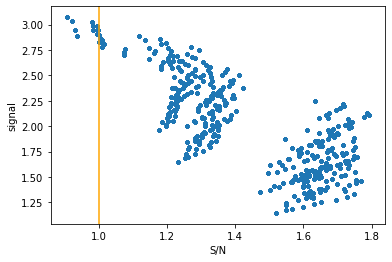

In [285]:
PARAMS = np.array(PARAMS)
plt.scatter(PARAMS[:,6],PARAMS[:,4],marker='.')
plt.axvline(1,color='orange')
plt.xlabel('S/N')
plt.ylabel('signal')
plt.show()

In [286]:


arr = np.argsort(PARAMS[:,-1])
PARAMS = PARAMS[arr[::-1]]
PARAMS
print(PARAMS[0])

[2.         0.25       0.32       0.42       2.11372202 1.18026639
 1.79088555]
